In [1]:
import numpy as np
import pandas as pd
import os
import requests
import io
from datetime import datetime, timedelta
import multiprocessing
import arviz as az
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from scipy.stats import poisson
import sqlite3

In [2]:
conn = sqlite3.connect(r"C:\Users\Owner\dev\team-eval\match_db.db")
df = pd.read_sql_query("""SELECT * FROM btb_matches""", conn)

df

,division_id,division,season_id,season,match_date,match_teams,home_team_id,home_team,away_team_id,away_team,...,home_deep,away_deep,home_ppda,away_ppda,bet365_home_odds,bet365_draw_odds,bet365_away_odds,bet365_u25_odds,bet365_o25_odds,match_id
0,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-16 00:00:00,Man United - Fulham,f2b82cdbdadf9d3ec47c3a6be66dcfad,Man United,8cd5e94668b139c1f42a89a1e130f3cf,Fulham,...,7.0,3.0,7.379310,10.833333,1.60,4.20,5.25,2.50,1.53,Man United - Fulham_20240816
1,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17 00:00:00,Newcastle - Southampton,78e9266876e7649e0a12e3840f5be006,Newcastle,5a884401673693b0bdf379fefb7ec2b2,Southampton,...,4.0,13.0,16.250000,3.789474,1.36,5.25,8.00,3.00,1.40,Newcastle - Southampton_20240817
2,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17 00:00:00,Arsenal - Wolves,4fc9baf210346939946d5a49f255588b,Arsenal,31f3ecbc5c48590ccc7dabaedd49a4ff,Wolves,...,14.0,2.0,7.769231,10.818182,1.18,7.50,13.00,2.75,1.44,Arsenal - Wolves_20240817
3,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17 00:00:00,Nott'm Forest - Bournemouth,9a8e1e9fad8766fc3d69a0c26d98b928,Nott'm Forest,b436d55f36cfbe8a085c8b75fb7fe98a,Bournemouth,...,10.0,4.0,8.653846,9.954545,2.45,3.50,2.80,2.10,1.73,Nott'm Forest - Bournemouth_20240817
4,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17 00:00:00,Ipswich - Liverpool,e4f63bf6d6d2cd121e6c8e59bef68209,Ipswich,afce84ff226407a47c9782a742ba02f7,Liverpool,...,2.0,13.0,18.777778,8.739130,8.50,5.50,1.33,3.00,1.40,Ipswich - Liverpool_20240817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,a290f895d08db6bb30a573aedf784bad,20202021,2021-05-08 00:00:00,Watford - Swansea,6e424e2cb43e11ef176c2a8dcb72f9de,Watford,013d5e8c67e9155030c74930aaf5be33,Swansea,...,NaN,NaN,NaN,NaN,2.00,3.40,3.80,1.85,2.00,Watford - Swansea_20210508
4469,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,a290f895d08db6bb30a573aedf784bad,20202021,2021-05-08 00:00:00,Middlesbrough - Wycombe,b4cb58c3a936665786359c2c634d6ff4,Middlesbrough,c7e249acd30a69cea63bc51a66e08807,Wycombe,...,NaN,NaN,NaN,NaN,1.75,4.00,4.33,2.10,1.72,Middlesbrough - Wycombe_20210508
4470,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,a290f895d08db6bb30a573aedf784bad,20202021,2021-05-08 00:00:00,Coventry - Millwall,9ed47047fb3b7f26ada9a35fe83d7b1b,Coventry,ea11a8d754f9bbf49dc01d6d3ae875d9,Millwall,...,NaN,NaN,NaN,NaN,2.37,3.50,2.87,1.80,2.00,Coventry - Millwall_20210508
4471,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,a290f895d08db6bb30a573aedf784bad,20202021,2021-05-08 00:00:00,Reading - Huddersfield,26fccddf2f94b1685b184267996e10f8,Reading,5668c64f7d3e02ee708188dbe0fdaa4e,Huddersfield,...,NaN,NaN,NaN,NaN,1.95,3.75,3.50,2.00,1.80,Reading - Huddersfield_20210508


In [3]:
final_df = pd.read_sql_query("""SELECT * FROM xgb_match_features_0065_001 WHERE division = 'Premier League'""", conn)

final_df[final_df["match_date"] > '2024-08-01'].to_csv("test_data.csv")

In [4]:
final_df["match_date"] = pd.to_datetime(final_df["match_date"])

final_df = final_df[final_df["match_date"] > '2020-12-31']

#final_df = final_df[final_df["division"] == "Premier League"]
final_df["xg_interaction"] = final_df["rolling_xg_for"] * final_df["opponent_rolling_xg_against"]
final_df["rolling_finishing_ability"] = final_df["rolling_goals_for"] - final_df["rolling_xg_for"]
final_df["rolling_opponent_finishing_ability"] = final_df["opponent_rolling_goals_against"] - final_df["opponent_rolling_xg_against"]

feature_cols = ["division", "home?", "avg_market_value", "opponent_avg_market_value", "rolling_finishing_ability", "rolling_opponent_finishing_ability", #"team_season", "opponent_team_season",#"xg_interaction",
             "rolling_goals_for", "rolling_xg_for", "rolling_shots_for", "rolling_shots_on_target_for", "rolling_corners_for", "rolling_deep_for", "rolling_ppda_for", 'rolling_goals_for_30d', 'rolling_goals_against_30d', 'rolling_xg_for_30d', 'rolling_xg_against_30d', 'rolling_shots_for_30d', 'rolling_shots_against_30d', 'rolling_shots_on_target_for_30d', 'rolling_shots_on_target_against_30d', 'rolling_corners_for_30d', 'rolling_corners_against_30d', 'rolling_deep_for_30d', 'rolling_deep_against_30d', 'rolling_ppda_for_30d', 'rolling_ppda_against_30d', 
             "opponent_rolling_goals_against", "opponent_rolling_xg_against", "opponent_rolling_shots_against", "opponent_rolling_shots_on_target_against", "opponent_rolling_corners_against", "opponent_rolling_deep_against", "opponent_rolling_ppda_against", 'opponent_rolling_goals_for_30d', 'opponent_rolling_goals_against_30d', 'opponent_rolling_xg_for_30d', 'opponent_rolling_xg_against_30d', 'opponent_rolling_shots_for_30d', 'opponent_rolling_shots_against_30d', 'opponent_rolling_shots_on_target_for_30d', 'opponent_rolling_shots_on_target_against_30d', 'opponent_rolling_corners_for_30d', 'opponent_rolling_corners_against_30d', 'opponent_rolling_deep_for_30d', 'opponent_rolling_deep_against_30d', 'opponent_rolling_ppda_for_30d', 'opponent_rolling_ppda_against_30d']

X = final_df[feature_cols]

# Convert categorical columns to category type
cat_cols = ["division"] #"team", "opponent_team"
for col in cat_cols:
    X[col] = X[col].astype('category')


y = final_df["goals"] 

text_cutoff = pd.to_datetime('2024-08-01')
X_train = X[final_df['match_date'] < text_cutoff]
y_train = y[final_df['match_date'] < text_cutoff]
X_test = X[final_df['match_date'] >= text_cutoff]
y_test = y[final_df['match_date'] >= text_cutoff]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

model_params = {
        'n_estimators': 100,
        'learning_rate': 0.03,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.9,
        'min_child_weight': 3,
        'gamma': 0.1,
        'alpha': 1,
        #'lambda_': 1,
        'random_state': 26,
        #'enable_categorical': True
    }


# Train an XGBoost model
model = xgb.XGBRegressor(objective='count:poisson', **model_params, enable_categorical= True)

model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Train MAE: {train_mae:.4f}")

X_test_has_nan = X_test.isna().any(axis=1)
y_test_has_nan = y_test.isna()

print(f"X_test rows with NaN: {X_test_has_nan.sum()}")
print(f"y_test rows with NaN: {y_test_has_nan.sum()}")

C:\Users\Owner\AppData\Local\Temp\ipykernel_22144\2447514632.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


Training set size: 2730 samples
Test set size: 578 samples
RMSE: 1.1781
Test MAE: 0.9275
Train MAE: 0.8415
X_test rows with NaN: 2
y_test rows with NaN: 0


In [5]:
# Get the test set indexes
test_indices = final_df.index[final_df['match_date'] >= text_cutoff]

# Create a temporary dataframe with all the test data
temp_df = final_df.loc[test_indices].copy()

# Initialize the predictions dataframe
match_preds = []

# Group by match_id to combine home and away rows
for match_id, group in temp_df.groupby('match_id'):
    if len(group) != 2:
        print(f"Warning: Match ID {match_id} does not have exactly 2 rows (has {len(group)})")
        continue
        
    # Get home and away rows
    home_row = group[group['home?'] == 1]
    away_row = group[group['home?'] == 0]
    
    if len(home_row) != 1 or len(away_row) != 1:
        print(f"Warning: Match ID {match_id} doesn't have one home and one away team")
        continue
    
    # Get the model predictions for both teams
    home_idx = home_row.index[0]
    away_idx = away_row.index[0]
    
    home_pred = y_pred[np.where(test_indices == home_idx)[0][0]] if home_idx in test_indices else None
    away_pred = y_pred[np.where(test_indices == away_idx)[0][0]] if away_idx in test_indices else None
    
    # Create a single row for this match
    match_data = {
        'match_id': match_id,
        'match_date': home_row['match_date'].values[0],
        'home_team': home_row['team'].values[0],
        'away_team': away_row['team'].values[0],
        'division': home_row['division'].values[0],
        'actual_home_goals': home_row['goals'].values[0],
        'actual_away_goals': away_row['goals'].values[0],
        'predicted_home_goals': home_pred,
        'predicted_away_goals': away_pred,
        'home_error': home_row['goals'].values[0] - home_pred if home_pred is not None else None,
        'away_error': away_row['goals'].values[0] - away_pred if away_pred is not None else None
    }
    
    # Add match_teams if available
    if 'match_teams' in home_row.columns:
        match_data['match_teams'] = home_row['match_teams'].values[0]
    
    match_preds.append(match_data)

# Create the final predictions dataframe
preds_df = pd.DataFrame(match_preds)

# Add some calculated columns
preds_df['home_abs_error'] = np.abs(preds_df['home_error'])
preds_df['away_abs_error'] = np.abs(preds_df['away_error'])
preds_df['total_abs_error'] = preds_df['home_abs_error'] + preds_df['away_abs_error']

# Save to CSV
#preds_df.to_csv("match_predictions.csv", index=False)

# Display summary stats
print("\nPrediction Summary:")
print(f"Total matches predicted: {len(preds_df)}")
print(f"Home goals MAE: {preds_df['home_abs_error'].mean():.4f}")
print(f"Away goals MAE: {preds_df['away_abs_error'].mean():.4f}")
print(f"Overall MAE: {(preds_df['home_abs_error'].mean() + preds_df['away_abs_error'].mean())/2:.4f}")
print(f"Date range: {preds_df['match_date'].min().date()} to {preds_df['match_date'].max().date()}")

preds_df


Prediction Summary:
Total matches predicted: 289
Home goals MAE: 0.9636
Away goals MAE: 0.8915
Overall MAE: 0.9275
Date range: 2024-08-16 to 2025-03-16


,match_id,match_date,home_team,away_team,division,actual_home_goals,actual_away_goals,predicted_home_goals,predicted_away_goals,home_error,away_error,home_abs_error,away_abs_error,total_abs_error
0,Arsenal - Aston Villa_20250118,2025-01-18,Arsenal,Aston Villa,Premier League,2,2,1.654242,1.030796,0.345758,0.969204,0.345758,0.969204,1.314963
1,Arsenal - Brighton_20240831,2024-08-31,Arsenal,Brighton,Premier League,1,1,1.896443,1.107668,-0.896443,-0.107668,0.896443,0.107668,1.004112
2,Arsenal - Chelsea_20250316,2025-03-16,Arsenal,Chelsea,Premier League,1,0,1.951345,1.099479,-0.951345,-1.099479,0.951345,1.099479,2.050824
3,Arsenal - Everton_20241214,2024-12-14,Arsenal,Everton,Premier League,0,0,2.165478,0.880981,-2.165478,-0.880981,2.165478,0.880981,3.046458
4,Arsenal - Ipswich_20241227,2024-12-27,Arsenal,Ipswich,Premier League,1,0,2.494205,0.801385,-1.494205,-0.801385,1.494205,0.801385,2.295591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Wolves - Man City_20241020,2024-10-20,Wolves,Man City,Premier League,1,2,1.053363,2.216520,-0.053363,-0.216520,0.053363,0.216520,0.269883
285,Wolves - Man United_20241226,2024-12-26,Wolves,Man United,Premier League,2,0,1.283266,1.484760,0.716734,-1.484760,0.716734,1.484760,2.201494
286,Wolves - Newcastle_20240915,2024-09-15,Wolves,Newcastle,Premier League,1,2,1.313203,1.881419,-0.313203,0.118581,0.313203,0.118581,0.431784
287,Wolves - Nott'm Forest_20250106,2025-01-06,Wolves,Nott'm Forest,Premier League,0,3,1.232422,1.250860,-1.232422,1.749140,1.232422,1.749140,2.981562


In [6]:
def append_df_to_sqlite_table(df_new, db_path, table_name, key_columns=None, batch_size=500):
    # Make a copy to avoid modifying the original dataframe
    df = df_new.copy()
    
    # Connect to the database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Check if table exists
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name=?", (table_name,))
    table_exists = cursor.fetchone() is not None
    
    if table_exists:
        # If key_columns not specified, use all columns
        if key_columns is None:
            key_columns = list(df.columns)
        
        # Get columns from existing table
        cursor.execute(f"PRAGMA table_info({table_name})")
        existing_columns = [row[1] for row in cursor.fetchall()]
        
        # Ensure all key columns exist in both dataframe and table
        key_columns = [col for col in key_columns if col in df.columns and col in existing_columns]
        
        if key_columns:
            # Process in batches to avoid SQL expression tree too large error
            filtered_dfs = []
            
            # Split dataframe into batches
            total_rows = len(df)
            for start_idx in range(0, total_rows, batch_size):
                end_idx = min(start_idx + batch_size, total_rows)
                batch_df = df.iloc[start_idx:end_idx]
                
                # For this batch, extract all key column values
                key_values = {}
                for key in key_columns:
                    key_values[key] = batch_df[key].tolist()
                
                # Build an optimized query - using IN clause for each key column
                where_clauses = []
                params = []
                
                for key in key_columns:
                    if len(key_values[key]) > 0:
                        placeholders = ','.join(['?'] * len(key_values[key]))
                        where_clauses.append(f"{key} IN ({placeholders})")
                        params.extend(key_values[key])
                
                if where_clauses:
                    # Get existing records
                    query = f"SELECT {', '.join(key_columns)} FROM {table_name} WHERE {' OR '.join(where_clauses)}"
                    cursor.execute(query, params)
                    existing_rows = cursor.fetchall()
                    
                    # Create a set of tuples representing existing rows
                    if key_columns:
                        existing_keys = set(existing_rows)
                        
                        # Filter out rows that already exist
                        batch_filtered = batch_df[~batch_df[key_columns].apply(tuple, axis=1).isin(existing_keys)]
                        if not batch_filtered.empty:
                            filtered_dfs.append(batch_filtered)
                else:
                    # No valid key values, include all rows
                    filtered_dfs.append(batch_df)
            
            # Combine all filtered batches
            if filtered_dfs:
                df_filtered = pd.concat(filtered_dfs, ignore_index=True)
                if not df_filtered.empty:
                    df_filtered.to_sql(table_name, conn, if_exists='append', index=False)
                    print(f"Added {len(df_filtered)} new records to table {table_name}")
                else:
                    print("No new records to append.")
            else:
                print("No new records to append.")
        else:
            # If no valid key columns, append all data (may create duplicates)
            df.to_sql(table_name, conn, if_exists='append', index=False)
            print(f"Warning: No valid key columns. Added all {len(df)} records to table {table_name}")
    else:
        # If table doesn't exist, create it with the new data
        df.to_sql(table_name, conn, index=False)
        print(f"Created new table {table_name} with {len(df)} records")
    
    # Close the connection
    conn.close()

append_df_to_sqlite_table(preds_df, 'match_db.db', 'xgb_pred_0065_001_prem20242025', key_columns=['match_id'])

No new records to append.


## Backtesting my model on 1x2 and o/u 2.5

In [7]:
backtest_df = pd.read_sql_query("""
    SELECT
        preds.match_id,
        preds.predicted_home_goals,
        preds.actual_home_goals,
        preds.predicted_away_goals,
        preds.actual_away_goals,
        btb.bet365_home_odds,
        btb.bet365_draw_odds,
        btb.bet365_away_odds,
        btb.bet365_u25_odds,
        btb.bet365_o25_odds
    FROM
        xgb_pred_0065_001_prem20242025 preds
    JOIN
        btb_matches btb
            ON btb.match_id = preds.match_id
                                
    """, conn)

backtest_df

,match_id,predicted_home_goals,actual_home_goals,predicted_away_goals,actual_away_goals,bet365_home_odds,bet365_draw_odds,bet365_away_odds,bet365_u25_odds,bet365_o25_odds
0,Arsenal - Aston Villa_20250118,1.590694,2,1.074542,2,1.50,4.10,7.00,2.03,1.87
1,Arsenal - Brighton_20240831,1.843244,1,1.144221,1,1.33,5.50,8.50,2.50,1.53
2,Arsenal - Chelsea_20250316,1.742448,1,1.133815,0,1.80,3.60,4.50,1.92,1.86
3,Arsenal - Everton_20241214,2.030706,0,0.932608,0,1.22,6.50,12.00,2.20,1.67
4,Arsenal - Ipswich_20241227,2.246113,1,0.899718,0,1.14,9.00,15.00,3.00,1.40
...,...,...,...,...,...,...,...,...,...,...
284,Wolves - Man City_20241020,1.058062,1,2.087760,2,8.00,6.00,1.33,2.75,1.44
285,Wolves - Man United_20241226,1.316546,2,1.455159,0,3.90,3.70,1.91,2.20,1.67
286,Wolves - Newcastle_20240915,1.290198,1,1.855103,2,3.40,3.50,2.10,2.38,1.57
287,Wolves - Nott'm Forest_20250106,1.245404,0,1.231543,3,3.30,3.20,2.30,1.73,2.10


In [8]:
def simulate_match_outcomes(home_goals, away_goals, num_simulations=10000):

    # Generate random samples from Poisson distributions
    home_scores = np.random.poisson(home_goals, num_simulations)
    away_scores = np.random.poisson(away_goals, num_simulations)
    
    # Calculate total goals for each simulation
    total_goals = home_scores + away_scores
    
    # Count outcomes
    home_wins = np.sum(home_scores > away_scores)
    draws = np.sum(home_scores == away_scores)
    away_wins = np.sum(home_scores < away_scores)
    
    # Count over/under 2.5 goals
    over_2_5 = np.sum(total_goals > 2.5)
    under_2_5 = np.sum(total_goals <= 2.5)
    
    # Convert to probabilities
    home_win_prob = home_wins / num_simulations
    draw_prob = draws / num_simulations
    away_win_prob = away_wins / num_simulations
    over_2_5_prob = over_2_5 / num_simulations
    under_2_5_prob = under_2_5 / num_simulations
    
    return {
        'home_win': home_win_prob,
        'draw': draw_prob,
        'away_win': away_win_prob,
        'over_2_5': over_2_5_prob,
        'under_2_5': under_2_5_prob
    }

# Add these probabilities to your prediction dataframe
backtest_df['probs'] = backtest_df.apply(
    lambda row: simulate_match_outcomes(row['predicted_home_goals'], row['predicted_away_goals']), 
    axis=1
)

# Extract individual probabilities to separate columns
backtest_df['home_win_prob'] = backtest_df['probs'].apply(lambda x: x['home_win'])
backtest_df['draw_prob'] = backtest_df['probs'].apply(lambda x: x['draw'])
backtest_df['away_win_prob'] = backtest_df['probs'].apply(lambda x: x['away_win'])
backtest_df['over_2_5_prob'] = backtest_df['probs'].apply(lambda x: x['over_2_5'])
backtest_df['under_2_5_prob'] = backtest_df['probs'].apply(lambda x: x['under_2_5'])

# Drop the intermediate dictionary column
backtest_df = backtest_df.drop('probs', axis=1)

append_df_to_sqlite_table(backtest_df, 'match_db.db', 'xgb_backtest_0065_001_prem20242025', key_columns=['match_id'])

backtest_df

No new records to append.


,match_id,predicted_home_goals,actual_home_goals,predicted_away_goals,actual_away_goals,bet365_home_odds,bet365_draw_odds,bet365_away_odds,bet365_u25_odds,bet365_o25_odds,home_win_prob,draw_prob,away_win_prob,over_2_5_prob,under_2_5_prob
0,Arsenal - Aston Villa_20250118,1.590694,2,1.074542,2,1.50,4.10,7.00,2.03,1.87,0.4889,0.2553,0.2558,0.4962,0.5038
1,Arsenal - Brighton_20240831,1.843244,1,1.144221,1,1.33,5.50,8.50,2.50,1.53,0.5378,0.2270,0.2352,0.5686,0.4314
2,Arsenal - Chelsea_20250316,1.742448,1,1.133815,0,1.80,3.60,4.50,1.92,1.86,0.5172,0.2354,0.2474,0.5516,0.4484
3,Arsenal - Everton_20241214,2.030706,0,0.932608,0,1.22,6.50,12.00,2.20,1.67,0.6196,0.2157,0.1647,0.5663,0.4337
4,Arsenal - Ipswich_20241227,2.246113,1,0.899718,0,1.14,9.00,15.00,3.00,1.40,0.6761,0.1830,0.1409,0.6048,0.3952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Wolves - Man City_20241020,1.058062,1,2.087760,2,8.00,6.00,1.33,2.75,1.44,0.1845,0.2098,0.6057,0.6068,0.3932
285,Wolves - Man United_20241226,1.316546,2,1.455159,0,3.90,3.70,1.91,2.20,1.67,0.3417,0.2585,0.3998,0.5238,0.4762
286,Wolves - Newcastle_20240915,1.290198,1,1.855103,2,3.40,3.50,2.10,2.38,1.57,0.2703,0.2252,0.5045,0.6072,0.3928
287,Wolves - Nott'm Forest_20250106,1.245404,0,1.231543,3,3.30,3.20,2.30,1.73,2.10,0.3611,0.2769,0.3620,0.4479,0.5521


In [9]:
def kelly_expected(probability, decimal_odds, fraction = 1.0):
    if decimal_odds <= 1 or probability <= 0 or probability >= 1:
        return 0, 0
        
    # Calculate Kelly Criterion
    q = 1 - probability  # probability of losing
    kelly = (probability * (decimal_odds - 1) - q) / (decimal_odds - 1) # win rate * potential profit subtracitng prob of losing. Divided by potentail profit
    kelly = kelly * fraction  # Apply fractional Kelly
    kelly = max(0, kelly)  # No negative bets
    
    # Calculate Expected Value
    ev = (probability * (decimal_odds - 1)) - (1 - probability)
    ev = ev  # Convert to percentage
    
    return kelly, ev

prob = 0.6398
odds = 1.67
fraction = 0.25

bet_size, ev = kelly_expected(prob, odds, fraction)
print(f"Optimal bet size: {bet_size:.1%}")
print(f"Expected Value: {ev:.1%}")


Optimal bet size: 2.6%
Expected Value: 6.8%


# 1x2 Backtesting

In [23]:
# Create dataframe with all 1X2 markets
market_1x2_df = pd.read_sql_query("""
    SELECT 
        match_id, 
        actual_home_goals, 
        actual_away_goals, 
        home_win_prob, draw_prob, away_win_prob,
        bet365_home_odds, bet365_draw_odds, bet365_away_odds 
    FROM xgb_backtest_0065_001_prem20242025
""", conn)

# Determine actual outcomes
market_1x2_df["home_win?"] = (market_1x2_df["actual_home_goals"] > market_1x2_df["actual_away_goals"]).astype(int)
market_1x2_df["draw?"] = (market_1x2_df["actual_home_goals"] == market_1x2_df["actual_away_goals"]).astype(int)
market_1x2_df["away_win?"] = (market_1x2_df["actual_away_goals"] > market_1x2_df["actual_home_goals"]).astype(int)

# Calculate Kelly stakes and EV for all three outcomes
# Home Win
home_results = market_1x2_df.apply(
    lambda row: kelly_expected(row['home_win_prob'], row['bet365_home_odds'], fraction=0.25),
    axis=1
)
market_1x2_df['home_kelly_stake'] = home_results.apply(lambda x: x[0])
market_1x2_df['home_ev_percent'] = home_results.apply(lambda x: x[1])
market_1x2_df['home_is_value_bet'] = (market_1x2_df['home_ev_percent'] > 0.00)

# Draw
draw_results = market_1x2_df.apply(
    lambda row: kelly_expected(row['draw_prob'], row['bet365_draw_odds'], fraction=0.25),
    axis=1
)
market_1x2_df['draw_kelly_stake'] = draw_results.apply(lambda x: x[0])
market_1x2_df['draw_ev_percent'] = draw_results.apply(lambda x: x[1])
market_1x2_df['draw_is_value_bet'] = (market_1x2_df['draw_ev_percent'] > 0.00)

# Away Win
away_results = market_1x2_df.apply(
    lambda row: kelly_expected(row['away_win_prob'], row['bet365_away_odds'], fraction=0.25),
    axis=1
)
market_1x2_df['away_kelly_stake'] = away_results.apply(lambda x: x[0])
market_1x2_df['away_ev_percent'] = away_results.apply(lambda x: x[1])
market_1x2_df['away_is_value_bet'] = (market_1x2_df['away_ev_percent'] > 0.00)

# Calculate profit for each market
market_1x2_df['home_profit'] = market_1x2_df.apply(
    lambda row: row['home_kelly_stake'] * (row['bet365_home_odds'] - 1) if row['home_is_value_bet'] and row['home_win?'] == 1 
              else (-row['home_kelly_stake'] if row['home_is_value_bet'] else 0),
    axis=1
)

market_1x2_df['draw_profit'] = market_1x2_df.apply(
    lambda row: row['draw_kelly_stake'] * (row['bet365_draw_odds'] - 1) if row['draw_is_value_bet'] and row['draw?'] == 1 
              else (-row['draw_kelly_stake'] if row['draw_is_value_bet'] else 0),
    axis=1
)

market_1x2_df['away_profit'] = market_1x2_df.apply(
    lambda row: row['away_kelly_stake'] * (row['bet365_away_odds'] - 1) if row['away_is_value_bet'] and row['away_win?'] == 1 
              else (-row['away_kelly_stake'] if row['away_is_value_bet'] else 0),
    axis=1
)

# Calculate total profit across all markets
market_1x2_df['total_profit'] = market_1x2_df['home_profit'] + market_1x2_df['draw_profit'] + market_1x2_df['away_profit']

# Display summary statistics for each market and overall
total_matches = len(market_1x2_df)
print(f"Total matches analyzed: {total_matches}")

# Home market
home_value_bets = market_1x2_df[market_1x2_df['home_is_value_bet']]
home_won_bets = home_value_bets['home_win?'].sum()
home_profit = home_value_bets['home_profit'].sum()
home_roi = (home_profit/len(home_value_bets)*100) if len(home_value_bets) > 0 else 0

# Draw market
draw_value_bets = market_1x2_df[market_1x2_df['draw_is_value_bet']]
draw_won_bets = draw_value_bets['draw?'].sum()
draw_profit = draw_value_bets['draw_profit'].sum()
draw_roi = (draw_profit/len(draw_value_bets)*100) if len(draw_value_bets) > 0 else 0

# Away market
away_value_bets = market_1x2_df[market_1x2_df['away_is_value_bet']]
away_won_bets = away_value_bets['away_win?'].sum()
away_profit = away_value_bets['away_profit'].sum()
away_roi = (away_profit/len(away_value_bets)*100) if len(away_value_bets) > 0 else 0

# Overall stats
all_value_bets = len(home_value_bets) + len(draw_value_bets) + len(away_value_bets)
total_profit = home_profit + draw_profit + away_profit
total_stake = home_value_bets['home_kelly_stake'].sum() + draw_value_bets['draw_kelly_stake'].sum() + away_value_bets['away_kelly_stake'].sum()
overall_roi = (total_profit/total_stake*100) if total_stake > 0 else 0

# Print results
print("\n=== HOME MARKET ===")
print(f"Value bets found: {len(home_value_bets)} ({len(home_value_bets)/total_matches:.1%} of total matches)")
if len(home_value_bets) > 0:
    print(f"Value bets won: {home_won_bets}/{len(home_value_bets)} ({home_won_bets/len(home_value_bets):.1%})")
    print(f"Total profit: {home_profit:.2f} units")
    print(f"ROI: {home_roi:.2f}%")

print("\n=== DRAW MARKET ===")
print(f"Value bets found: {len(draw_value_bets)} ({len(draw_value_bets)/total_matches:.1%} of total matches)")
if len(draw_value_bets) > 0:
    print(f"Value bets won: {draw_won_bets}/{len(draw_value_bets)} ({draw_won_bets/len(draw_value_bets):.1%})")
    print(f"Total profit: {draw_profit:.2f} units")
    print(f"ROI: {draw_roi:.2f}%")

print("\n=== AWAY MARKET ===")
print(f"Value bets found: {len(away_value_bets)} ({len(away_value_bets)/total_matches:.1%} of total matches)")
if len(away_value_bets) > 0:
    print(f"Value bets won: {away_won_bets}/{len(away_value_bets)} ({away_won_bets/len(away_value_bets):.1%})")
    print(f"Total profit: {away_profit:.2f} units")
    print(f"ROI: {away_roi:.2f}%")

print("\n=== OVERALL PERFORMANCE ===")
print(f"Total value bets: {all_value_bets} (average {all_value_bets/total_matches:.1f} bets per match)")
print(f"Total profit: {total_profit:.2f} units")
print(f"Overall ROI: {overall_roi:.2f}%")

# Additional analysis: compare market performance
best_market = max([("Home", home_roi), ("Draw", draw_roi), ("Away", away_roi)], key=lambda x: x[1])
print(f"\nBest performing market: {best_market[0]} (ROI: {best_market[1]:.2f}%)")

# Check for matches with multiple value bets
market_1x2_df['value_bet_count'] = (
    market_1x2_df['home_is_value_bet'].astype(int) + 
    market_1x2_df['draw_is_value_bet'].astype(int) + 
    market_1x2_df['away_is_value_bet'].astype(int)
)
multi_value_matches = market_1x2_df[market_1x2_df['value_bet_count'] > 1]
print(f"\nMatches with multiple value bets: {len(multi_value_matches)} ({len(multi_value_matches)/total_matches:.1%} of total)")

Total matches analyzed: 289

=== HOME MARKET ===
Value bets found: 85 (29.4% of total matches)
Value bets won: 15/85 (17.6%)
Total profit: -0.80 units
ROI: -0.94%

=== DRAW MARKET ===
Value bets found: 92 (31.8% of total matches)
Value bets won: 21/92 (22.8%)
Total profit: -0.07 units
ROI: -0.08%

=== AWAY MARKET ===
Value bets found: 193 (66.8% of total matches)
Value bets won: 53/193 (27.5%)
Total profit: 0.45 units
ROI: 0.23%

=== OVERALL PERFORMANCE ===
Total value bets: 370 (average 1.3 bets per match)
Total profit: -0.42 units
Overall ROI: -6.54%

Best performing market: Away (ROI: 0.23%)

Matches with multiple value bets: 93 (32.2% of total)


In [30]:
ft_backtest_df = pd.read_sql_query("""
    SELECT
        preds.match_id,
        preds.predicted_home_goals,
        preds.actual_home_goals,
        preds.predicted_away_goals,
        preds.actual_away_goals,
        preds.home_win_prob, draw_prob, away_win_prob,                           
        eo.B365H,
        eo.B365D,
        eo.B365A,
        eo.B365CH,
        eo.B365CD,
        eo.B365CA
    FROM
        xgb_backtest_0065_001_prem20242025 preds
    JOIN
        epl_odds eo
            ON eo.match_id = preds.match_id
                                
    """, conn)

home_results = ft_backtest_df.apply(
    lambda row: kelly_expected(row['home_win_prob'], row['B365H'], fraction=0.25),
    axis=1
)
ft_backtest_df['home_kelly_stake'] = home_results.apply(lambda x: x[0])
ft_backtest_df['home_ev_percent'] = home_results.apply(lambda x: x[1])
ft_backtest_df['home_is_value_bet'] = (ft_backtest_df['home_ev_percent'] > 0.02)

draw_results = ft_backtest_df.apply(
    lambda row: kelly_expected(row['draw_prob'], row['B365D'], fraction=0.25),
    axis=1
)
ft_backtest_df['draw_kelly_stake'] = draw_results.apply(lambda x: x[0])
ft_backtest_df['draw_ev_percent'] = draw_results.apply(lambda x: x[1])
ft_backtest_df['draw_is_value_bet'] = (ft_backtest_df['draw_ev_percent'] > 0.02)

away_results = ft_backtest_df.apply(
    lambda row: kelly_expected(row['away_win_prob'], row['B365A'], fraction=0.25),
    axis=1
)
ft_backtest_df['away_kelly_stake'] = away_results.apply(lambda x: x[0])
ft_backtest_df['away_ev_percent'] = away_results.apply(lambda x: x[1])
ft_backtest_df['away_is_value_bet'] = (ft_backtest_df['away_ev_percent'] > 0.02)

ft_backtest_df

,match_id,predicted_home_goals,actual_home_goals,predicted_away_goals,actual_away_goals,home_win_prob,draw_prob,away_win_prob,B365H,B365D,...,B365CA,home_kelly_stake,home_ev_percent,home_is_value_bet,draw_kelly_stake,draw_ev_percent,draw_is_value_bet,away_kelly_stake,away_ev_percent,away_is_value_bet
0,Arsenal - Aston Villa_20250118,1.590694,2,1.074542,2,0.4920,0.2501,0.2579,1.50,4.10,...,6.25,0.000000,-0.262000,False,0.002049,0.02541,True,0.033554,0.805300,True
1,Arsenal - Brighton_20240831,1.843244,1,1.144221,1,0.5370,0.2282,0.2348,1.33,5.50,...,7.50,0.000000,-0.285790,False,0.014172,0.25510,True,0.033193,0.995800,True
2,Arsenal - Chelsea_20250316,1.742448,1,1.133815,0,0.5070,0.2392,0.2538,1.80,3.60,...,5.25,0.000000,-0.087400,False,0.000000,-0.13888,False,0.010150,0.142100,True
3,Arsenal - Everton_20241214,2.030706,0,0.932608,0,0.6321,0.2080,0.1599,1.22,6.50,...,13.00,0.000000,-0.228838,False,0.016000,0.35200,True,0.020882,0.918800,True
4,Arsenal - Ipswich_20241227,2.246113,1,0.899718,0,0.6753,0.1849,0.1398,1.14,9.00,...,17.00,0.000000,-0.230158,False,0.020753,0.66410,True,0.019589,1.097000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Wolves - Man City_20241020,1.058062,1,2.087760,2,0.1817,0.1964,0.6219,8.00,6.00,...,1.33,0.016200,0.453600,True,0.008920,0.17840,True,0.000000,-0.172873,False
285,Wolves - Man United_20241226,1.316546,2,1.455159,0,0.3374,0.2542,0.4084,3.90,3.70,...,1.80,0.027229,0.315860,True,0.000000,-0.05946,False,0.000000,-0.219956,False
286,Wolves - Newcastle_20240915,1.290198,1,1.855103,2,0.2623,0.2260,0.5117,3.40,3.50,...,2.05,0.000000,-0.108180,False,0.000000,-0.20900,False,0.016948,0.074570,True
287,Wolves - Nott'm Forest_20250106,1.245404,0,1.231543,3,0.3756,0.2698,0.3546,3.30,3.20,...,1.95,0.026030,0.239480,True,0.000000,-0.13664,False,0.000000,-0.184420,False


In [ ]:
import tqdm
def bootstrap_1x2_closing(ft_backtest_df, n_bootstraps=1000):
    results = []
    n_bets = len(ft_backtest_df)

    for _ in tqdm.tqdm(range(n_bootstraps)):
        # Sample with replacement
        bootstrap_indices = np.random.choice(n_bets, size=n_bets, replace=True)
        bootstrap_sample = ft_backtest_df.iloc[bootstrap_indices].copy()
        
        # Simulate match outcomes based on closing odds
        for idx, row in bootstrap_sample.iterrows():
            # Convert closing odds to implied probabilities
            home_close_prob = 1 / row['B365CH']
            draw_close_prob = 1 / row['B365CD']
            away_close_prob = 1 / row['B365CA']
            
            # Normalize to remove overround
            total_prob = home_close_prob + draw_close_prob + away_close_prob
            home_close_prob /= total_prob
            draw_close_prob /= total_prob
            away_close_prob /= total_prob
            
            # Simulate outcome based on closing odds probabilities
            outcome_probs = [home_close_prob, draw_close_prob, away_close_prob]
            simulated_outcome = np.random.choice(["home", "draw", "away"], p=outcome_probs)
            
            # Set outcome flags
            bootstrap_sample.at[idx, 'home_win?'] = 1 if simulated_outcome == "home" else 0
            bootstrap_sample.at[idx, 'draw?'] = 1 if simulated_outcome == "draw" else 0
            bootstrap_sample.at[idx, 'away_win?'] = 1 if simulated_outcome == "away" else 0
        
        # Calculate profit for each market based on simulated outcomes
        bootstrap_sample['home_profit'] = bootstrap_sample.apply(
            lambda row: row['home_kelly_stake'] * (row['B365H'] - 1) if row['home_is_value_bet'] and row['home_win?'] == 1 
                      else (-row['home_kelly_stake'] if row['home_is_value_bet'] else 0),
            axis=1
        )
        
        bootstrap_sample['draw_profit'] = bootstrap_sample.apply(
            lambda row: row['draw_kelly_stake'] * (row['B365D'] - 1) if row['draw_is_value_bet'] and row['draw?'] == 1 
                      else (-row['draw_kelly_stake'] if row['draw_is_value_bet'] else 0),
            axis=1
        )
        
        bootstrap_sample['away_profit'] = bootstrap_sample.apply(
            lambda row: row['away_kelly_stake'] * (row['B365A'] - 1) if row['away_is_value_bet'] and row['away_win?'] == 1 
                      else (-row['away_kelly_stake'] if row['away_is_value_bet'] else 0),
            axis=1
        )
        
        # Calculate total profit
        bootstrap_sample['total_profit'] = bootstrap_sample['home_profit'] + bootstrap_sample['draw_profit'] + bootstrap_sample['away_profit']
        
        # Count value bets by market
        home_value_bets = bootstrap_sample[bootstrap_sample['home_is_value_bet']]
        draw_value_bets = bootstrap_sample[bootstrap_sample['draw_is_value_bet']]
        away_value_bets = bootstrap_sample[bootstrap_sample['away_is_value_bet']]
        
        # Calculate metrics for this bootstrap sample
        home_profit = home_value_bets['home_profit'].sum() if len(home_value_bets) > 0 else 0
        draw_profit = draw_value_bets['draw_profit'].sum() if len(draw_value_bets) > 0 else 0
        away_profit = away_value_bets['away_profit'].sum() if len(away_value_bets) > 0 else 0
        total_profit = home_profit + draw_profit + away_profit
        
        # Calculate total stakes
        home_stake = home_value_bets['home_kelly_stake'].sum() if len(home_value_bets) > 0 else 0
        draw_stake = draw_value_bets['draw_kelly_stake'].sum() if len(draw_value_bets) > 0 else 0
        away_stake = away_value_bets['away_kelly_stake'].sum() if len(away_value_bets) > 0 else 0
        total_stake = home_stake + draw_stake + away_stake
        
        # Calculate ROI
        overall_roi = (total_profit / total_stake * 100) if total_stake > 0 else 0
        
        # Calculate win rate (bets that won out of all bets placed)
        home_wins = home_value_bets['home_win?'].sum() if len(home_value_bets) > 0 else 0
        draw_wins = draw_value_bets['draw?'].sum() if len(draw_value_bets) > 0 else 0
        away_wins = away_value_bets['away_win?'].sum() if len(away_value_bets) > 0 else 0
        total_wins = home_wins + draw_wins + away_wins
        total_bets = len(home_value_bets) + len(draw_value_bets) + len(away_value_bets)
        win_rate = (total_wins / total_bets * 100) if total_bets > 0 else 0
        
        results.append({
            'total_profit': total_profit,
            'roi': overall_roi,
            'win_rate': win_rate,
            'bets_with_outcome': total_bets,
            'home_profit': home_profit,
            'draw_profit': draw_profit, 
            'away_profit': away_profit,
            'home_bets': len(home_value_bets),
            'draw_bets': len(draw_value_bets),
            'away_bets': len(away_value_bets)
        })
    
    return pd.DataFrame(results)

# Run bootstrap simulation
bootstrap_results = bootstrap_1x2_closing(ft_backtest_df, n_bootstraps=1000)

# Display summary statistics
print("=== BOOTSTRAP RESULTS (1000 simulations) ===")
print(f"Average Total Profit: {bootstrap_results['total_profit'].mean():.2f} units")
print(f"Profit 95% CI: [{bootstrap_results['total_profit'].quantile(0.025):.2f}, {bootstrap_results['total_profit'].quantile(0.975):.2f}]")
print(f"Average ROI: {bootstrap_results['roi'].mean():.2f}%")
print(f"ROI 95% CI: [{bootstrap_results['roi'].quantile(0.025):.2f}%, {bootstrap_results['roi'].quantile(0.975):.2f}%]")
print(f"Average Win Rate: {bootstrap_results['win_rate'].mean():.2f}%")
print(f"Win Rate 95% CI: [{bootstrap_results['win_rate'].quantile(0.025):.2f}%, {bootstrap_results['win_rate'].quantile(0.975):.2f}%]")

# Average bets per market
print(f"\nAverage bets per bootstrap sample:")
print(f"Home bets: {bootstrap_results['home_bets'].mean():.1f}")
print(f"Draw bets: {bootstrap_results['draw_bets'].mean():.1f}")
print(f"Away bets: {bootstrap_results['away_bets'].mean():.1f}")
print(f"Total bets: {bootstrap_results['bets_with_outcome'].mean():.1f}")



100%|██████████| 1000/1000 [01:34<00:00, 10.62it/s]

=== BOOTSTRAP RESULTS (1000 simulations) ===
Average Total Profit: -0.34 units
Profit 95% CI: [-2.37, 2.27]
Average ROI: -5.29%
ROI 95% CI: [-37.00%, 35.95%]
Average Win Rate: 22.12%
Win Rate 95% CI: [16.81%, 28.28%]

Average bets per bootstrap sample:
Home bets: 78.1
Draw bets: 79.7
Away bets: 188.2
Total bets: 346.0


TypeError: cannot unpack non-iterable Figure object

<Figure size 1400x1000 with 0 Axes>

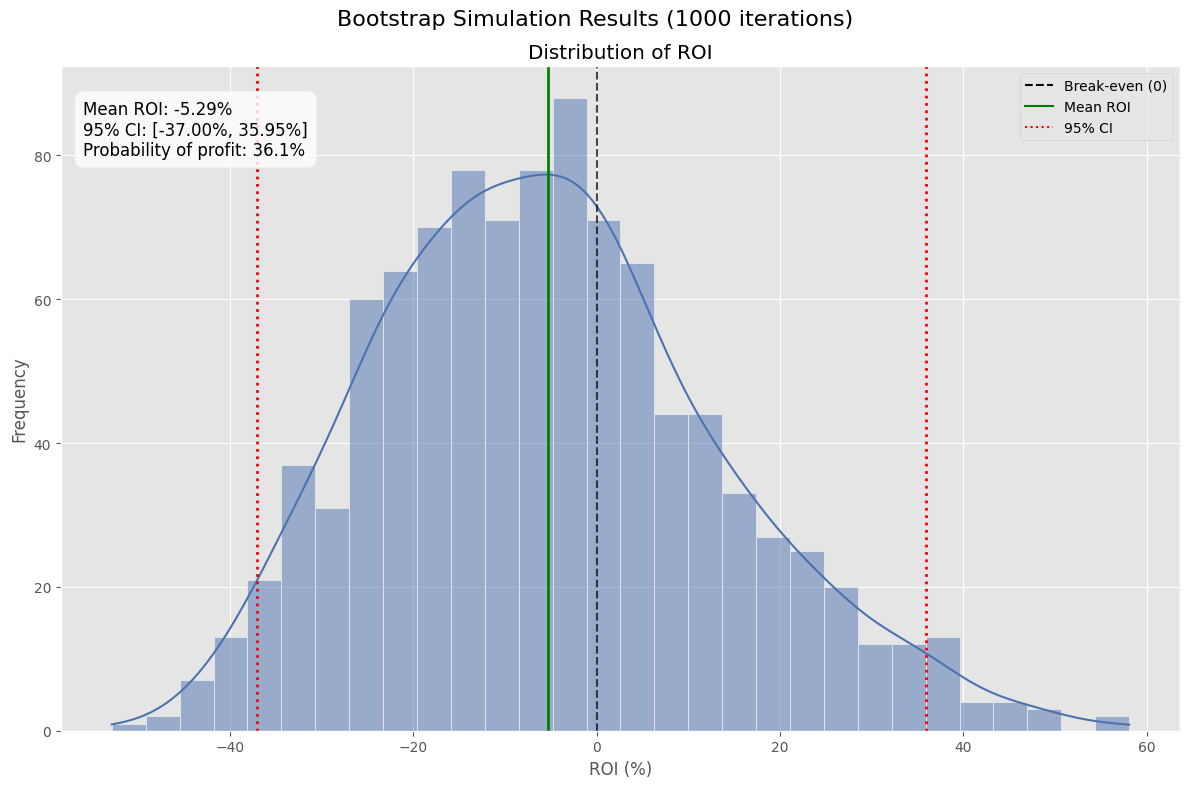

In [34]:
# Set up a nicer style for the plots
plt.style.use('ggplot')
sns.set_palette("deep")

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Bootstrap Simulation Results (1000 iterations)', fontsize=16)

# Plot ROI Distribution
sns.histplot(bootstrap_results['roi'], bins=30, kde=True, ax=ax)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.7)
ax.axvline(x=bootstrap_results['roi'].mean(), color='green', linestyle='-', linewidth=2)
ax.axvline(x=bootstrap_results['roi'].quantile(0.025), color='red', linestyle=':', linewidth=2)
ax.axvline(x=bootstrap_results['roi'].quantile(0.975), color='red', linestyle=':', linewidth=2)
ax.set_title('Distribution of ROI')
ax.set_xlabel('ROI (%)')
ax.set_ylabel('Frequency')

# Add a legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', label='Break-even (0)'),
    Line2D([0], [0], color='green', label='Mean ROI'),
    Line2D([0], [0], color='red', linestyle=':', label='95% CI')
]
ax.legend(handles=legend_elements, loc='upper right')

# Add text annotation with key statistics
mean_roi = bootstrap_results['roi'].mean()
ci_lower = bootstrap_results['roi'].quantile(0.025)
ci_upper = bootstrap_results['roi'].quantile(0.975)
profit_probability = (bootstrap_results['roi'] > 0).mean() * 100

stats_text = f"Mean ROI: {mean_roi:.2f}%\n95% CI: [{ci_lower:.2f}%, {ci_upper:.2f}%]\nProbability of profit: {profit_probability:.1f}%"
plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
             va='top', fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
over_25_df = pd.read_sql_query("""SELECT match_id, actual_home_goals, actual_away_goals, over_2_5_prob, bet365_o25_odds FROM xgb_backtest_0065_001_prem20242025""", conn)

over_25_df["over_25?"] = (over_25_df["actual_away_goals"] + over_25_df["actual_home_goals"] > 2.5).astype(int)

results = over_25_df.apply(
    lambda row: kelly_expected(row['over_2_5_prob'], row['bet365_o25_odds'], fraction=0.25),
    axis=1
)

# Extract Kelly and EV values into separate columns
over_25_df['kelly_stake'] = results.apply(lambda x: x[0])
over_25_df['ev_percent'] = results.apply(lambda x: x[1])
over_25_df['is_value_bet'] = (over_25_df['ev_percent'] > 0.02) 

over_25_df['profit'] = over_25_df.apply(
    lambda row: row['kelly_stake'] * (row['bet365_o25_odds'] - 1) if row['is_value_bet'] and row['over_25?'] == 1 
              else (-row['kelly_stake'] if row['is_value_bet'] else 0),  # Lose Kelly stake for lost bets
    axis=1
)

# Display summary statistics
value_bets = over_25_df[over_25_df['is_value_bet']]
print(f"Total matches analyzed: {len(over_25_df)}")
print(f"Value bets found: {len(value_bets)} ({len(value_bets)/len(over_25_df):.1%} of total)")

if len(value_bets) > 0:
    # Calculate performance of value bets
    won_bets = value_bets['over_25?'].sum()
    profit = value_bets['profit'].sum()
    
    print(f"Value bets won: {won_bets}/{len(value_bets)} ({won_bets/len(value_bets):.1%})")
    print(f"Total profit: {profit:.2f} units")
    print(f"ROI: {profit/len(value_bets)*100:.2f}%")

Total matches analyzed: 289
Value bets found: 33 (11.4% of total)
Value bets won: 16/33 (48.5%)
Total profit: -0.07 units
ROI: -0.22%


In [14]:
under_25_df = pd.read_sql_query("""SELECT match_id, actual_home_goals, actual_away_goals, under_2_5_prob, bet365_u25_odds FROM xgb_backtest_0065_001_prem20242025""", conn)

under_25_df["under_25?"] = (under_25_df["actual_away_goals"] + under_25_df["actual_home_goals"] <= 2.5).astype(int)

results = under_25_df.apply(
    lambda row: kelly_expected(row['under_2_5_prob'], row['bet365_u25_odds'], fraction=0.25),
    axis=1
)

# Extract Kelly and EV values into separate columns
under_25_df['kelly_stake'] = results.apply(lambda x: x[0])
under_25_df['ev_percent'] = results.apply(lambda x: x[1])
under_25_df['is_value_bet'] = under_25_df['ev_percent'] > 0.02

under_25_df['profit'] = under_25_df.apply(
    lambda row: row['kelly_stake'] * (row['bet365_u25_odds'] - 1) if row['is_value_bet'] and row['under_25?'] == 1 
              else (-row['kelly_stake'] if row['is_value_bet'] else 0),  # Lose Kelly stake for lost bets
    axis=1
)

# Display summary statistics
value_bets = under_25_df[under_25_df['is_value_bet']]
print(f"Total matches analyzed: {len(under_25_df)}")
print(f"Value bets found: {len(value_bets)} ({len(value_bets)/len(under_25_df):.1%} of total)")

if len(value_bets) > 0:
    # Calculate performance of value bets
    won_bets = value_bets['under_25?'].sum()
    profit = value_bets['profit'].sum()
    
    print(f"Value bets won: {won_bets}/{len(value_bets)} ({won_bets/len(value_bets):.1%})")
    print(f"Total profit: {profit:.2f} units")
    print(f"ROI: {profit/len(value_bets)*100:.2f}%")

Total matches analyzed: 289
Value bets found: 130 (45.0% of total)
Value bets won: 42/130 (32.3%)
Total profit: -0.11 units
ROI: -0.08%


# Asian Handicap Testing

In [15]:
ah_backtest_df = pd.read_sql_query("""
    SELECT
        preds.match_id,
        preds.predicted_home_goals,
        preds.actual_home_goals,
        preds.predicted_away_goals,
        preds.actual_away_goals,
        eo.AHh,
        eo.B365AHH,
        eo.B365AHA,
        eo.AHCh,
        eo.B365CAHH,
        eo.B365CAHA
    FROM
        xgb_pred_0065_001_prem20242025 preds
    JOIN
        epl_odds eo
            ON eo.match_id = preds.match_id
                                
    """, conn)

ah_backtest_df

,match_id,predicted_home_goals,actual_home_goals,predicted_away_goals,actual_away_goals,AHh,B365AHH,B365AHA,AHCh,B365CAHH,B365CAHA
0,Arsenal - Aston Villa_20250118,1.590694,2,1.074542,2,-1.00,1.87,2.03,-1.00,1.98,1.92
1,Arsenal - Brighton_20240831,1.843244,1,1.144221,1,-1.50,2.01,1.89,-1.50,2.08,1.85
2,Arsenal - Chelsea_20250316,1.742448,1,1.133815,0,-0.75,2.06,1.84,-0.75,1.95,1.95
3,Arsenal - Everton_20241214,2.030706,0,0.932608,0,-1.75,1.95,1.95,-1.75,2.05,1.88
4,Arsenal - Ipswich_20241227,2.246113,1,0.899718,0,-2.25,2.04,1.89,-2.25,2.02,1.91
...,...,...,...,...,...,...,...,...,...,...,...
284,Wolves - Man City_20241020,1.058062,1,2.087760,2,1.50,2.02,1.88,1.50,1.85,2.08
285,Wolves - Man United_20241226,1.316546,2,1.455159,0,0.50,1.95,1.95,0.75,1.87,2.06
286,Wolves - Newcastle_20240915,1.290198,1,1.855103,2,0.25,2.06,1.84,0.50,1.85,2.08
287,Wolves - Nott'm Forest_20250106,1.245404,0,1.231543,3,0.25,1.91,1.99,0.50,1.88,2.02


In [16]:
def calculate_ah_probs(df, random_seed=26, n_sims=50000):
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Define a function to apply to each row
    def calc_probs_for_row(row):
        np.random.seed(random_seed)
        
        home_pred_goals = row['predicted_home_goals']
        away_pred_goals = row['predicted_away_goals']
        line = row['AHh']
        
        home_goals = np.random.poisson(home_pred_goals, size=n_sims)
        away_goals = np.random.poisson(away_pred_goals, size=n_sims)
        home_goal_diff = home_goals - away_goals
        
        if line % 0.5 == 0.25 or line % 0.5 == -0.25:
            # Split into two lines
            lower_line = np.floor(line)
            upper_line = np.floor(line) + 0.5
            
            # If it's a negative quarter (e.g., -0.25), swap the order
            if line % 1 == -0.25:
                lower_line = np.ceil(line)
                upper_line = np.ceil(line) - 0.5
            
            # Calculate probabilities for each part
            # For lower line
            lower_wins = np.sum((home_goal_diff + lower_line) > 0)
            lower_draws = np.sum((home_goal_diff + lower_line) == 0)
            lower_losses = np.sum((home_goal_diff + lower_line) < 0)
            
            # For upper line
            upper_wins = np.sum((home_goal_diff + upper_line) > 0)
            upper_draws = np.sum((home_goal_diff + upper_line) == 0)
            upper_losses = np.sum((home_goal_diff + upper_line) < 0)
            
            # Combine results (50% weight to each line)
            home_prob = ((lower_wins + 0.5 * lower_draws) + (upper_wins + 0.5 * upper_draws)) / (2 * n_sims)
            away_prob = ((lower_losses + 0.5 * lower_draws) + (upper_losses + 0.5 * upper_draws)) / (2 * n_sims)
        
        else:
            # Handle regular lines (0, whole, half)
            home_wins = np.sum((home_goal_diff + line) > 0)
            draws = np.sum((home_goal_diff + line) == 0)
            away_wins = np.sum((home_goal_diff + line) < 0)
            
            home_prob = (home_wins + 0.5 * draws) / n_sims
            away_prob = (away_wins + 0.5 * draws) / n_sims
        
        return pd.Series({'home_win_prob': home_prob, 'away_win_prob': away_prob})
    
    # Apply the function to each row
    probs = result_df.apply(calc_probs_for_row, axis=1)
    
    # Add the calculated probabilities to the result dataframe
    result_df['home_win_prob'] = probs['home_win_prob']
    result_df['away_win_prob'] = probs['away_win_prob']
    
    return result_df

ah_backtest_df = calculate_ah_probs(ah_backtest_df)

ah_backtest_df

,match_id,predicted_home_goals,actual_home_goals,predicted_away_goals,actual_away_goals,AHh,B365AHH,B365AHA,AHCh,B365CAHH,B365CAHA,home_win_prob,away_win_prob
0,Arsenal - Aston Villa_20250118,1.590694,2,1.074542,2,-1.00,1.87,2.03,-1.00,1.98,1.92,0.377230,0.622770
1,Arsenal - Brighton_20240831,1.843244,1,1.144221,1,-1.50,2.01,1.89,-1.50,2.08,1.85,0.305520,0.694480
2,Arsenal - Chelsea_20250316,1.742448,1,1.133815,0,-0.75,2.06,1.84,-0.75,1.95,1.95,0.460385,0.539615
3,Arsenal - Everton_20241214,2.030706,0,0.932608,0,-1.75,1.95,1.95,-1.75,2.05,1.88,0.339585,0.660415
4,Arsenal - Ipswich_20241227,2.246113,1,0.899718,0,-2.25,2.04,1.89,-2.25,2.02,1.91,0.210130,0.789870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Wolves - Man City_20241020,1.058062,1,2.087760,2,1.50,2.02,1.88,1.50,1.85,2.08,0.625780,0.374220
285,Wolves - Man United_20241226,1.316546,2,1.455159,0,0.50,1.95,1.95,0.75,1.87,2.06,0.599540,0.400460
286,Wolves - Newcastle_20240915,1.290198,1,1.855103,2,0.25,2.06,1.84,0.50,1.85,2.08,0.440675,0.559325
287,Wolves - Nott'm Forest_20250106,1.245404,0,1.231543,3,0.25,1.91,1.99,0.50,1.88,2.02,0.573710,0.426290


In [17]:
def calculate_ah_results(df):
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Define a function to calculate the result for a single row
    def calc_result_for_row(row):
        home_goals = row['actual_home_goals']
        away_goals = row['actual_away_goals']
        line = row['AHh']
        
        # Calculate adjusted home score
        adjusted_home = home_goals + line
        goal_diff = adjusted_home - away_goals
        
        # Result values for home bet
        home_result = 0
        
        # For quarter lines
        if line % 0.5 == 0.25 or line % 0.5 == -0.25:
            lower_line = np.floor(line)
            upper_line = np.floor(line) + 0.5
            
            # If it's a negative quarter (e.g., -0.25), swap the order
            if line % 1 == -0.25:
                lower_line = np.ceil(line)
                upper_line = np.ceil(line) - 0.5
                
            lower_diff = (home_goals + lower_line) - away_goals
            upper_diff = (home_goals + upper_line) - away_goals
            
            # Calculate combined result
            if lower_diff > 0 and upper_diff > 0:
                home_result = 1.0  # Full win
            elif lower_diff == 0 and upper_diff > 0:
                home_result = 0.75  # Half-win, half-push
            elif lower_diff > 0 and upper_diff == 0:
                home_result = 0.75  # Half-win, half-push
            elif lower_diff == 0 and upper_diff == 0:
                home_result = 0.5  # Push
            elif lower_diff < 0 and upper_diff == 0:
                home_result = 0.25  # Half-push, half-loss
            elif lower_diff == 0 and upper_diff < 0:
                home_result = 0.25  # Half-push, half-loss
            else:
                home_result = 0.0  # Full loss
        
        # For whole or half lines
        else:
            if goal_diff > 0:
                home_result = 1.0  # Win
            elif goal_diff == 0:
                home_result = 0.5  # Push
            else:
                home_result = 0.0  # Loss
        
        # Away result is the complement of home result
        away_result = 1.0 - home_result
        
        return pd.Series({'home_ah_result': home_result, 'away_ah_result': away_result})
    
    # Apply the function to each row
    results = result_df.apply(calc_result_for_row, axis=1)
    
    # Add the calculated results to the result dataframe
    result_df['home_ah_result'] = results['home_ah_result']
    result_df['away_ah_result'] = results['away_ah_result']
    
    return result_df

ah_backtest_df = calculate_ah_results(ah_backtest_df)

ah_backtest_df

,match_id,predicted_home_goals,actual_home_goals,predicted_away_goals,actual_away_goals,AHh,B365AHH,B365AHA,AHCh,B365CAHH,B365CAHA,home_win_prob,away_win_prob,home_ah_result,away_ah_result
0,Arsenal - Aston Villa_20250118,1.590694,2,1.074542,2,-1.00,1.87,2.03,-1.00,1.98,1.92,0.377230,0.622770,0.00,1.00
1,Arsenal - Brighton_20240831,1.843244,1,1.144221,1,-1.50,2.01,1.89,-1.50,2.08,1.85,0.305520,0.694480,0.00,1.00
2,Arsenal - Chelsea_20250316,1.742448,1,1.133815,0,-0.75,2.06,1.84,-0.75,1.95,1.95,0.460385,0.539615,0.75,0.25
3,Arsenal - Everton_20241214,2.030706,0,0.932608,0,-1.75,1.95,1.95,-1.75,2.05,1.88,0.339585,0.660415,0.00,1.00
4,Arsenal - Ipswich_20241227,2.246113,1,0.899718,0,-2.25,2.04,1.89,-2.25,2.02,1.91,0.210130,0.789870,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Wolves - Man City_20241020,1.058062,1,2.087760,2,1.50,2.02,1.88,1.50,1.85,2.08,0.625780,0.374220,1.00,0.00
285,Wolves - Man United_20241226,1.316546,2,1.455159,0,0.50,1.95,1.95,0.75,1.87,2.06,0.599540,0.400460,1.00,0.00
286,Wolves - Newcastle_20240915,1.290198,1,1.855103,2,0.25,2.06,1.84,0.50,1.85,2.08,0.440675,0.559325,0.00,1.00
287,Wolves - Nott'm Forest_20250106,1.245404,0,1.231543,3,0.25,1.91,1.99,0.50,1.88,2.02,0.573710,0.426290,0.00,1.00


In [18]:
# Calculate Kelly and EV for home bets
home_results = ah_backtest_df.apply(
    lambda row: kelly_expected(row['home_win_prob'], row['B365AHH'], fraction=0.25),
    axis=1
)

# Calculate Kelly and EV for away bets
away_results = ah_backtest_df.apply(
    lambda row: kelly_expected(row['away_win_prob'], row['B365AHA'], fraction=0.25),
    axis=1
)

# Extract values into columns
ah_backtest_df['home_kelly_stake'] = home_results.apply(lambda x: x[0])
ah_backtest_df['home_ev_percent'] = home_results.apply(lambda x: x[1])
ah_backtest_df['away_kelly_stake'] = away_results.apply(lambda x: x[0])
ah_backtest_df['away_ev_percent'] = away_results.apply(lambda x: x[1])

# Determine which side has better EV
ah_backtest_df['better_side'] = ah_backtest_df.apply(
    lambda row: 'home' if row['home_ev_percent'] > row['away_ev_percent'] else 'away',
    axis=1
)


ah_backtest_df

,match_id,predicted_home_goals,actual_home_goals,predicted_away_goals,actual_away_goals,AHh,B365AHH,B365AHA,AHCh,B365CAHH,B365CAHA,home_win_prob,away_win_prob,home_ah_result,away_ah_result,home_kelly_stake,home_ev_percent,away_kelly_stake,away_ev_percent,better_side
0,Arsenal - Aston Villa_20250118,1.590694,2,1.074542,2,-1.00,1.87,2.03,-1.00,1.98,1.92,0.377230,0.622770,0.00,1.00,0.000000,-0.294580,0.064132,0.264223,away
1,Arsenal - Brighton_20240831,1.843244,1,1.144221,1,-1.50,2.01,1.89,-1.50,2.08,1.85,0.305520,0.694480,0.00,1.00,0.000000,-0.385905,0.087800,0.312567,away
2,Arsenal - Chelsea_20250316,1.742448,1,1.133815,0,-0.75,2.06,1.84,-0.75,1.95,1.95,0.460385,0.539615,0.75,0.25,0.000000,-0.051607,0.000000,-0.007108,away
3,Arsenal - Everton_20241214,2.030706,0,0.932608,0,-1.75,1.95,1.95,-1.75,2.05,1.88,0.339585,0.660415,0.00,1.00,0.000000,-0.337809,0.075739,0.287809,away
4,Arsenal - Ipswich_20241227,2.246113,1,0.899718,0,-2.25,2.04,1.89,-2.25,2.02,1.91,0.210130,0.789870,0.00,1.00,0.000000,-0.571335,0.138442,0.492854,away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Wolves - Man City_20241020,1.058062,1,2.087760,2,1.50,2.02,1.88,1.50,1.85,2.08,0.625780,0.374220,1.00,0.00,0.064724,0.264076,0.000000,-0.296466,home
285,Wolves - Man United_20241226,1.316546,2,1.455159,0,0.50,1.95,1.95,0.75,1.87,2.06,0.599540,0.400460,1.00,0.00,0.044501,0.169103,0.000000,-0.219103,home
286,Wolves - Newcastle_20240915,1.290198,1,1.855103,2,0.25,2.06,1.84,0.50,1.85,2.08,0.440675,0.559325,0.00,1.00,0.000000,-0.092210,0.008678,0.029158,away
287,Wolves - Nott'm Forest_20250106,1.245404,0,1.231543,3,0.25,1.91,1.99,0.50,1.88,2.02,0.573710,0.426290,0.00,1.00,0.026315,0.095786,0.000000,-0.151683,home


In [19]:
line_diff = ah_backtest_df[ah_backtest_df["AHh"] != ah_backtest_df["AHCh"]]
line_same = ah_backtest_df[ah_backtest_df["AHh"] == ah_backtest_df["AHCh"]]

line_same.shape

(171, 20)

In [38]:
# Helper function to calculate profit based on chosen side
def calculate_bet_profit(row):
    if not row['is_value_bet']:
        return 0
        
    if row['better_side'] == 'home':
        stake = row['home_kelly_stake']
        odds = row['B365AHH']
        result = row['home_ah_result']
    else:  # away
        stake = row['away_kelly_stake']
        odds = row['B365AHA']
        result = row['away_ah_result']
    
    if result == 1.0:  # Full win
        return stake * (odds - 1)
    elif result == 0.75:  # 3/4 win
        return stake * (odds - 1) * 0.75
    elif result == 0.5:  # Push
        return 0
    elif result == 0.25:  # 1/4 win
        return stake * (odds - 1) * 0.25
    else:  # Full loss
        return -stake

# Determine if it's a value bet based on the better side
ah_backtest_df['is_value_bet'] = ah_backtest_df.apply(
    lambda row: row['home_ev_percent'] > 0.19 if row['better_side'] == 'home' 
                else row['away_ev_percent'] > 0.19,
    axis=1
)

# Calculate profit based on which side we bet on
ah_backtest_df['profit'] = ah_backtest_df.apply(
    lambda row: calculate_bet_profit(row),
    axis=1
)

# Display summary statistics
value_bets = ah_backtest_df[ah_backtest_df['is_value_bet']]
print(f"Total matches analyzed: {len(ah_backtest_df)}")
print(f"Value bets found: {len(value_bets)} ({len(value_bets)/len(ah_backtest_df):.1%} of total)")
print(f"Home bets: {sum(value_bets['better_side'] == 'home')}")
print(f"Away bets: {sum(value_bets['better_side'] == 'away')}")

if len(value_bets) > 0:
    # Group results by the chosen side
    home_bets = value_bets[value_bets['better_side'] == 'home']
    away_bets = value_bets[value_bets['better_side'] == 'away']
    
    # Overall performance
    profit = value_bets['profit'].sum()
    pushes = sum((value_bets['better_side'] == 'home') & (value_bets['home_ah_result'] == 0.5)) + \
             sum((value_bets['better_side'] == 'away') & (value_bets['away_ah_result'] == 0.5))
    
    # For ROI, we exclude pushes
    bets_with_outcome = len(value_bets) - pushes
    
    print(f"\nOverall performance:")
    print(f"Total profit: {profit:.2f} units")
    if bets_with_outcome > 0:
        print(f"ROI: {profit/bets_with_outcome*100:.2f}% (excluding pushes)")
    
    # Performance by side
    if len(home_bets) > 0:
        home_profit = home_bets['profit'].sum()
        home_pushes = sum(home_bets['home_ah_result'] == 0.5)
        home_bets_with_outcome = len(home_bets) - home_pushes
        
        print(f"\nHome bets performance:")
        print(f"Profit: {home_profit:.2f} units")
        if home_bets_with_outcome > 0:
            print(f"ROI: {home_profit/home_bets_with_outcome*100:.2f}%")
    
    if len(away_bets) > 0:
        away_profit = away_bets['profit'].sum()
        away_pushes = sum(away_bets['away_ah_result'] == 0.5)
        away_bets_with_outcome = len(away_bets) - away_pushes
        
        print(f"\nAway bets performance:")
        print(f"Profit: {away_profit:.2f} units")
        if away_bets_with_outcome > 0:
            print(f"ROI: {away_profit/away_bets_with_outcome*100:.2f}%")

Total matches analyzed: 289
Value bets found: 112 (38.8% of total)
Home bets: 14
Away bets: 98

Overall performance:
Total profit: 3.13 units
ROI: 2.95% (excluding pushes)

Home bets performance:
Profit: -0.25 units
ROI: -1.90%

Away bets performance:
Profit: 3.37 units
ROI: 3.63%


#### Bootstrapping +EV AH bets

In [39]:
bootstrap_ah_df = pd.merge(
    ah_backtest_df,
    df[['match_id', 'home_xgoals', 'away_xgoals']],  # Only select these columns from df
    on='match_id'
)

bootstrap_ah_df

,match_id,predicted_home_goals,actual_home_goals,predicted_away_goals,actual_away_goals,AHh,B365AHH,B365AHA,AHCh,B365CAHH,...,away_ah_result,home_kelly_stake,home_ev_percent,away_kelly_stake,away_ev_percent,better_side,is_value_bet,profit,home_xgoals,away_xgoals
0,Arsenal - Aston Villa_20250118,1.590694,2,1.074542,2,-1.00,1.87,2.03,-1.00,1.98,...,1.00,0.000000,-0.294580,0.064132,0.264223,away,True,0.066056,1.644580,1.206020
1,Arsenal - Brighton_20240831,1.843244,1,1.144221,1,-1.50,2.01,1.89,-1.50,2.08,...,1.00,0.000000,-0.385905,0.087800,0.312567,away,True,0.078142,2.417980,1.817480
2,Arsenal - Chelsea_20250316,1.742448,1,1.133815,0,-0.75,2.06,1.84,-0.75,1.95,...,0.25,0.000000,-0.051607,0.000000,-0.007108,away,False,0.000000,0.695725,0.286036
3,Arsenal - Everton_20241214,2.030706,0,0.932608,0,-1.75,1.95,1.95,-1.75,2.05,...,1.00,0.000000,-0.337809,0.075739,0.287809,away,True,0.071952,1.308650,0.132166
4,Arsenal - Ipswich_20241227,2.246113,1,0.899718,0,-2.25,2.04,1.89,-2.25,2.02,...,1.00,0.000000,-0.571335,0.138442,0.492854,away,True,0.123214,2.164620,0.078333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Wolves - Man City_20241020,1.058062,1,2.087760,2,1.50,2.02,1.88,1.50,1.85,...,0.00,0.064724,0.264076,0.000000,-0.296466,home,True,0.066019,0.761217,1.365690
285,Wolves - Man United_20241226,1.316546,2,1.455159,0,0.50,1.95,1.95,0.75,1.87,...,0.00,0.044501,0.169103,0.000000,-0.219103,home,False,0.000000,0.826489,0.358876
286,Wolves - Newcastle_20240915,1.290198,1,1.855103,2,0.25,2.06,1.84,0.50,1.85,...,1.00,0.000000,-0.092210,0.008678,0.029158,away,False,0.000000,1.469690,1.483430
287,Wolves - Nott'm Forest_20250106,1.245404,0,1.231543,3,0.25,1.91,1.99,0.50,1.88,...,1.00,0.026315,0.095786,0.000000,-0.151683,home,False,0.000000,1.904630,2.572270


100%|██████████| 1000/1000 [00:37<00:00, 26.85it/s]


Bootstrap Results:
Mean Profit: 3.14 units
Mean ROI: 2.89%
95% Confidence Interval for ROI: [1.46%, 4.22%]
Probability of Profit: 100.00%


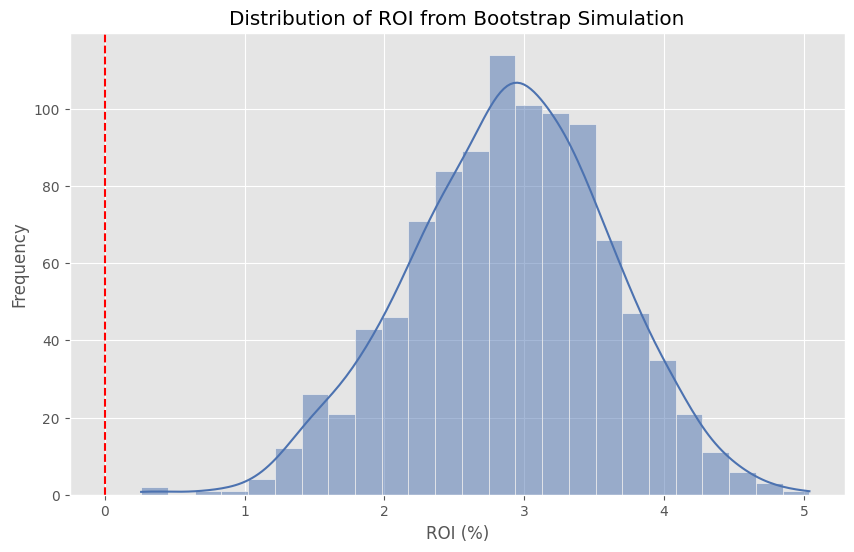

In [40]:
from tqdm import tqdm

def bootstrap(ev_bets, n_bootstraps=1000):
    results = []
    n_bets = len(ev_bets)

    for _ in tqdm(range(n_bootstraps)):
        bootstrap_indices = np.random.choice(n_bets, size=n_bets, replace=True)
        bootstrap_sample = ev_bets.iloc[bootstrap_indices]

        sim_df = bootstrap_sample.copy()

        for idx, row in sim_df.iterrows():
            home_xg = row['home_xgoals']
            away_xg = row['away_xgoals']

            simulated_home_goals = np.random.poisson(home_xg)
            simulated_away_goals = np.random.poisson(away_xg)

            sim_df.at[idx, 'actual_home_goals'] = simulated_home_goals
            sim_df.at[idx, 'actual_away_goals'] = simulated_away_goals

        sim_df = calculate_ah_results(sim_df)

        sim_df["profit"] - sim_df.apply(calculate_bet_profit, axis=1)

        # Calculate key metrics for this bootstrap sample
        total_profit = sim_df['profit'].sum()
        
        # Calculate ROI excluding pushes
        pushes = sum((sim_df['better_side'] == 'home') & (sim_df['home_ah_result'] == 0.5)) + \
                 sum((sim_df['better_side'] == 'away') & (sim_df['away_ah_result'] == 0.5))
        bets_with_outcome = len(sim_df) - pushes
        
        roi = total_profit / bets_with_outcome if bets_with_outcome > 0 else 0
        
        # Calculate win rate (full wins + partial wins)
        win_count = sum((sim_df['better_side'] == 'home') & (sim_df['home_ah_result'] > 0.5)) + \
                    sum((sim_df['better_side'] == 'away') & (sim_df['away_ah_result'] > 0.5))
        partial_win_count = sum((sim_df['better_side'] == 'home') & (sim_df['home_ah_result'] == 0.25)) + \
                            sum((sim_df['better_side'] == 'away') & (sim_df['away_ah_result'] == 0.25))
        
        win_rate = (win_count + 0.5 * partial_win_count) / bets_with_outcome if bets_with_outcome > 0 else 0
        
        results.append({
            'total_profit': total_profit,
            'roi': roi * 100,  # Convert to percentage
            'win_rate': win_rate * 100,  # Convert to percentage
            'bets_with_outcome': bets_with_outcome
        })
    
    return pd.DataFrame(results)

def bootstrap_closing_odds(same_line_ev_bets, n_bootstraps=1000):
    results = []
    n_bets = len(same_line_ev_bets)

    for _ in tqdm(range(n_bootstraps)):
        bootstrap_indices = np.random.choice(n_bets, size=n_bets, replace=True)
        bootstrap_sample = same_line_ev_bets.iloc[bootstrap_indices]

        sim_df = bootstrap_sample.copy()

        for idx, row in sim_df.iterrows():
            home_xg = row['home_xgoals']
            away_xg = row['away_xgoals']

            simulated_home_goals = np.random.poisson(home_xg)
            simulated_away_goals = np.random.poisson(away_xg)

            sim_df.at[idx, 'actual_home_goals'] = simulated_home_goals
            sim_df.at[idx, 'actual_away_goals'] = simulated_away_goals

        sim_df = calculate_ah_results(sim_df)

        sim_df["profit"] - sim_df.apply(calculate_bet_profit, axis=1)

        # Calculate key metrics for this bootstrap sample
        total_profit = sim_df['profit'].sum()
        
        # Calculate ROI excluding pushes
        pushes = sum((sim_df['better_side'] == 'home') & (sim_df['home_ah_result'] == 0.5)) + \
                 sum((sim_df['better_side'] == 'away') & (sim_df['away_ah_result'] == 0.5))
        bets_with_outcome = len(sim_df) - pushes
        
        roi = total_profit / bets_with_outcome if bets_with_outcome > 0 else 0
        
        # Calculate win rate (full wins + partial wins)
        win_count = sum((sim_df['better_side'] == 'home') & (sim_df['home_ah_result'] > 0.5)) + \
                    sum((sim_df['better_side'] == 'away') & (sim_df['away_ah_result'] > 0.5))
        partial_win_count = sum((sim_df['better_side'] == 'home') & (sim_df['home_ah_result'] == 0.25)) + \
                            sum((sim_df['better_side'] == 'away') & (sim_df['away_ah_result'] == 0.25))
        
        win_rate = (win_count + 0.5 * partial_win_count) / bets_with_outcome if bets_with_outcome > 0 else 0
        
        results.append({
            'total_profit': total_profit,
            'roi': roi * 100,  # Convert to percentage
            'win_rate': win_rate * 100,  # Convert to percentage
            'bets_with_outcome': bets_with_outcome
        })
    
    return pd.DataFrame(results)

value_bets_df = bootstrap_ah_df[bootstrap_ah_df['is_value_bet']] 
# Run bootstrap
bootstrap_results = bootstrap(value_bets_df, n_bootstraps=1000)

# Display bootstrap statistics
print("Bootstrap Results:")
print(f"Mean Profit: {bootstrap_results['total_profit'].mean():.2f} units")
print(f"Mean ROI: {bootstrap_results['roi'].mean():.2f}%")
print(f"95% Confidence Interval for ROI: [{np.percentile(bootstrap_results['roi'], 2.5):.2f}%, {np.percentile(bootstrap_results['roi'], 97.5):.2f}%]")
print(f"Probability of Profit: {(bootstrap_results['total_profit'] > 0).mean():.2%}")

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_results['roi'], kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribution of ROI from Bootstrap Simulation')
plt.xlabel('ROI (%)')
plt.ylabel('Frequency')
plt.show()
        



C:\Users\Owner\AppData\Local\Temp\ipykernel_22144\2375322489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ev_percent'] = df.apply(
C:\Users\Owner\AppData\Local\Temp\ipykernel_22144\2375322489.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ev_bin'] = pd.qcut(df['ev_percent'], num_bins, labels=False)


EV Bin Analysis:
           EV Bin  Average EV (%)  Total Bets  Total Profit   ROI (%)  \
0  0.192 to 0.228        0.211611          23      0.501539  2.507693   
1  0.228 to 0.276        0.252274          22      0.866319  4.125326   
2  0.276 to 0.322        0.297857          22      0.444750  2.223751   
3  0.322 to 0.394        0.354460          22      0.667181  3.032640   
4  0.394 to 0.696        0.474405          23      0.647742  2.816270   

   Win Rate (%)  
0     72.500000  
1     80.952381  
2     65.000000  
3     65.909091  
4     58.695652  


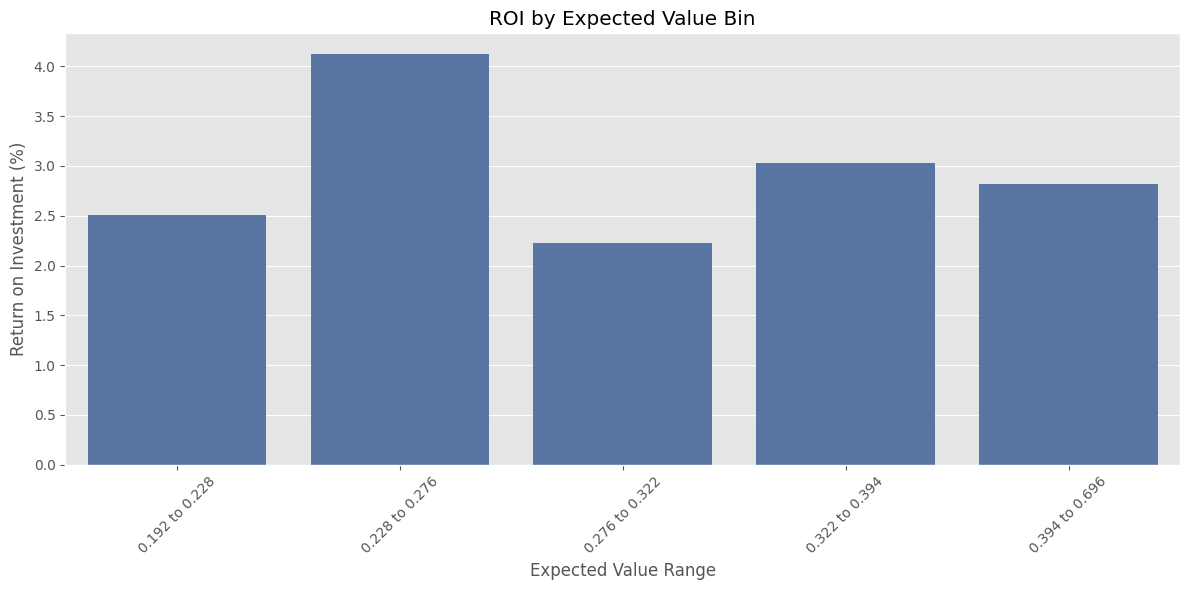

In [41]:
def analyze_ev_bins(df, num_bins=5):
    # Create a unified EV column based on which side was bet on
    df['ev_percent'] = df.apply(
        lambda row: row['home_ev_percent'] if row['better_side'] == 'home' else row['away_ev_percent'], 
        axis=1
    )
    
    # Create EV bins
    df['ev_bin'] = pd.qcut(df['ev_percent'], num_bins, labels=False)
    
    # Get bin ranges for labeling
    bin_edges = pd.qcut(df['ev_percent'], num_bins, retbins=True)[1]
    bin_labels = [f"{bin_edges[i]:.3f} to {bin_edges[i+1]:.3f}" for i in range(len(bin_edges)-1)]
    
    results = []
    
    for bin_idx in range(num_bins):
        bin_df = df[df['ev_bin'] == bin_idx]
        
        # Skip empty bins
        if len(bin_df) == 0:
            continue
            
        # Calculate metrics for this bin
        total_bets = len(bin_df)
        
        # Count pushes
        pushes = sum((bin_df['better_side'] == 'home') & (bin_df['home_ah_result'] == 0.5)) + \
                 sum((bin_df['better_side'] == 'away') & (bin_df['away_ah_result'] == 0.5))
        
        bets_with_outcome = total_bets - pushes
        
        # Calculate profit and ROI
        total_profit = bin_df['profit'].sum()
        roi = (total_profit / bets_with_outcome) * 100 if bets_with_outcome > 0 else 0
        
        # Calculate win rates
        win_count = sum((bin_df['better_side'] == 'home') & (bin_df['home_ah_result'] > 0.5)) + \
                    sum((bin_df['better_side'] == 'away') & (bin_df['away_ah_result'] > 0.5))
                    
        partial_win_count = sum((bin_df['better_side'] == 'home') & (bin_df['home_ah_result'] == 0.25)) + \
                            sum((bin_df['better_side'] == 'away') & (bin_df['away_ah_result'] == 0.25))
        
        win_rate = (win_count + 0.5 * partial_win_count) / bets_with_outcome * 100 if bets_with_outcome > 0 else 0
        
        # Average EV
        avg_ev = bin_df['ev_percent'].mean()
        
        results.append({
            'EV Bin': bin_labels[bin_idx],
            'Average EV (%)': avg_ev,
            'Total Bets': total_bets,
            'Total Profit': total_profit,
            'ROI (%)': roi,
            'Win Rate (%)': win_rate
        })
    
    return pd.DataFrame(results)


ev_bin_analysis = analyze_ev_bins(value_bets_df, num_bins=5)
print("EV Bin Analysis:")
print(ev_bin_analysis)

# Create visualization for ROI by EV bin
plt.figure(figsize=(12, 6))
sns.barplot(x='EV Bin', y='ROI (%)', data=ev_bin_analysis)
plt.title('ROI by Expected Value Bin')
plt.xlabel('Expected Value Range')
plt.ylabel('Return on Investment (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()